# Encuesta nacional de gastos de los hogares

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
import requests
from io import BytesIO
from zipfile import ZipFile


En este apartado podemos verificar las diferentes bibliotecas que utilizamos para desarrollar el OLS.

In [2]:
# URL del archivo zip
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/engho/engho2018_hogares.zip"

# Descargar el contenido del archivo zip
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

# Obtener la lista de archivos en el zip para encontrar el archivo .txt
files = zip_file.namelist()

# Encontrar el nombre del archivo .txt
txt_file_name = [file for file in files if file.endswith('.txt')][0]

Obtenemos la Encuesta nacional de gastos de los hogares directamente desde la pagina del INDEC, como el archivo viene por defecto dentro de un archivo .ZIP debemos extraer el archivo y declarar de que se trata de un archivo .txt

In [3]:
def filtro1(data, i, region=False):
    n = data.shape[0]
    if region:
        n_data = data[data['region'] == i]
    else:
        n_data = data[data['provincia'] == i]
    fn_data = n_data.drop(['region', 'provincia', 'id', 'hacina', 'jcomed', 'gastot', 'ingtoth'], axis=1)
    fn_data = fn_data[fn_data['gastotpc'] >=0]
    fn_data = fn_data[fn_data['ingpch'] >=0]
    # Gasto bajo es un gasto por debajo de la media de la suma de los primeros 3 grupos de gasto
    g3 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03']).mean()
    g6 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06']).mean()
    g9 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06'] + fn_data['gc09_07'] + fn_data['gc09_08'] + fn_data['gc09_09']).mean()
    gasto = []
    l = np.array(fn_data[['gc09_01', 'gc09_02', 'gc09_03', 'gc09_04', 'gc09_05', 'gc09_06', 'gc09_07', 'gc09_08', 'gc09_09']].values.tolist())
    for i in range(l.shape[0]):
        gasto.append(int(l[i][0:2].sum() > g3) + int(l[i][0:5].sum() > g6) + int(l[i][0:8].sum() > g9))
    fn_data['gasto'] = gasto

    data['ingpch'] = data['ingpch']*data['pondera']
    data['gastotpc'] = data['gastotpc']*data['pondera']
     #ingch
    fn_data['ingpch2'] = pow(fn_data['ingpch'],2)

    # propauto
    fn_data['propauto'] = fn_data['propauto'].apply(lambda x: 1 if x in [2, 3] else 0)

    # regten regimen de tenencia
    fn_data['regten'] = fn_data['regten'].apply(lambda x: 1 if x == 1 else 0)

    # jniveled
    fn_data['prim'] = fn_data['jniveled'].apply(lambda x: 1 if x in [2, 3] else 0)
    fn_data['sec'] = fn_data['jniveled'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['univ'] = fn_data['jniveled'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jniveled'], axis=1)
    
    #jedadAgrupada
    fn_data['edad_25/34'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['edad_35/49'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['edad65_mas'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jedad_agrup'], axis=1)
    
    #Estado civil
    fn_data['casado'] = fn_data['jsitconyugal'].apply(lambda x: 1 if x in [1, 2] else 0)

    fn_data['jestado'] = fn_data['jestado'].apply(lambda x: 1 if x == 1 else 0)

    fn_data['asalariado'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 1 else 0)
    fn_data['propia_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 2 else 0)
    fn_data['propia_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['socio_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 4 else 0)
    fn_data['socio_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 5 else 0)
    fn_data = fn_data.drop(['jocupengh'], axis=1)

    fn_data['jpercept'] = fn_data['jpercept'] - 1

    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: 0 if x == 99 else x)
    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: round(fn_data['clima_educativo'].mean()) if x == 0 else x)
    return fn_data

In [4]:
def plot_histograma_gasto(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['gasto'], bins=10, color='skyblue', edgecolor='black')
    plt.title('Gasto, en 4 categorias')
    plt.xlabel('Gasto')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

In [5]:
def plot_histograma_gasto_percapita(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['gastotpc'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Gasto(Log)')
    plt.xlabel('Log del Gasto per capita')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

Definir el proposito de este grafico

In [6]:
def plot_histograma_ingpch(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['ingpch'], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Histograma del Ingreso per Cápita (Log)')
    plt.xlabel('Log del Ingreso per Cápita')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

Definir el proposito de este grafico

In [7]:
def plot_bar_gasto_educacion(df):
    gasto_promedio_educacion = df.groupby(['prim', 'sec', 'univ'])['gasto'].mean().reset_index()
    gasto_promedio_educacion['Educación'] = gasto_promedio_educacion.apply(
        lambda row: 'Primaria' if row['prim'] == 1 else ('Secundaria' if row['sec'] == 1 else 'Universitaria'),
        axis=1
    )
    plt.figure(figsize=(10, 6))
    plt.bar(gasto_promedio_educacion['Educación'], gasto_promedio_educacion['gasto'], color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Promedio de Gasto por Nivel de Educación')
    plt.xlabel('Nivel de Educación')
    plt.ylabel('Gasto Promedio')
    plt.grid(True)
    plt.show()

Definir el proposito de este grafico

                            OLS Regression Results                            
Dep. Variable:               gastotpc   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     540.7
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:08:46   Log-Likelihood:                -40633.
No. Observations:                3909   AIC:                         8.129e+04
Df Residuals:                    3898   BIC:                         8.136e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             383.9079    819.171     

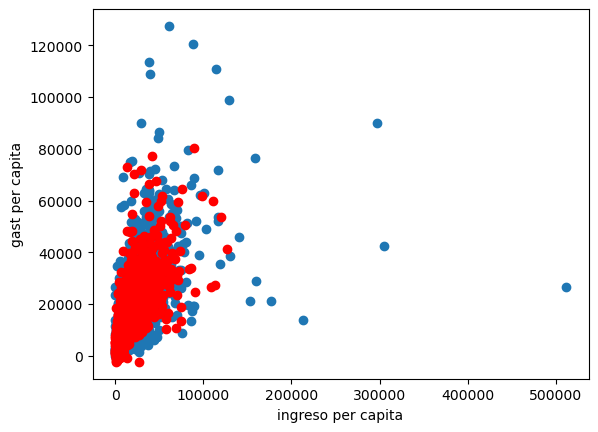

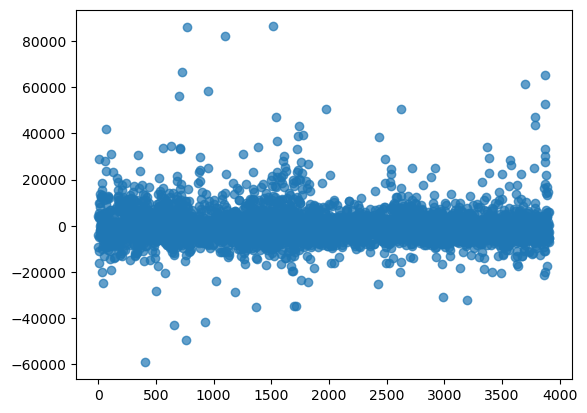

In [8]:
if __name__ == "__main__":
    with zip_file.open(txt_file_name) as file:
        data = pd.read_csv(file, delimiter='|')
        
    with zip_file.open(txt_file_name) as file:
        data_metro = pd.read_csv(file, delimiter='|')
        
    with zip_file.open(txt_file_name) as file:
        data_pampe = pd.read_csv(file, delimiter='|')
    
    #Region 1
    fdata_metro = filtro1(data_metro,1, region=True)
    n = fdata_metro.shape[0]
    '''
    X = fdata_nea['ingpch']
    X = sm.add_constant(X)
    y = fdata_nea[['gastotpc']]
    reg1 = sm.OLS(y, X).fit()
    print(reg1.summary())
    '''
    X = fdata_metro[['ingpch','ingpch2','clima_educativo', 'asalariado', 'casado','regten', 'propauto', 'edad_25/34', 'edad_35/49', 'edad65_mas']]
    X = sm.add_constant(X)
    y = fdata_metro[['gastotpc']]
    reg2 = sm.OLS(y, X).fit()
    print(reg2.summary())
    predicciones = reg2.predict(X)
    plt.scatter(fdata_metro['ingpch'],fdata_metro['gastotpc'])
    plt.scatter(fdata_metro['gastotpc'], predicciones, label='Valores predichos', color='red')
    plt.ylabel('gast per capita')
    plt.xlabel('ingreso per capita')
    plt.show()
    residuos = reg2.resid
    plt.scatter(range(len(residuos)), residuos, alpha=0.7)
    plt.show()
    
    
  
    
   
    #plot_histograma_gasto(fdata_nea)
    #plot_histograma_gasto_percapita(fdata_nea)
    #plot_histograma_ingpch(fdata_nea)
    #plot_bar_gasto_educacion(fdata_nea)
    


                            OLS Regression Results                            
Dep. Variable:               gastotpc   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     506.6
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:09:02   Log-Likelihood:                -54062.
No. Observations:                5307   AIC:                         1.081e+05
Df Residuals:                    5296   BIC:                         1.082e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2221.3947    510.659     

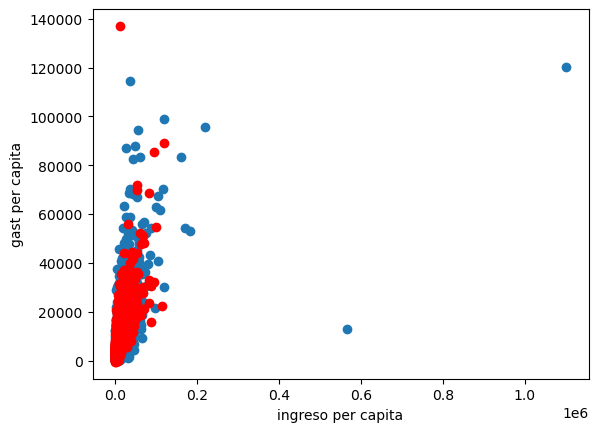

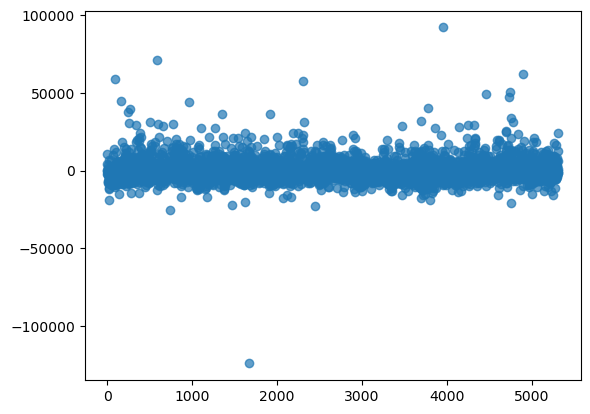

In [10]:
#Region 2
fdata_pampe = filtro1(data_pampe, 2, region=True)
n = fdata_pampe.shape[0]
'''
X = fdata_nea['ingpch']
X = sm.add_constant(X)
y = fdata_nea[['gastotpc']]
reg1 = sm.OLS(y, X).fit()
print(reg1.summary())
'''
X = fdata_pampe[['ingpch','ingpch2','clima_educativo', 'asalariado', 'casado','regten', 'propauto', 'edad_25/34', 'edad_35/49', 'edad65_mas']]
X = sm.add_constant(X)
y = fdata_pampe[['gastotpc']]
reg2 = sm.OLS(y, X).fit()
print(reg2.summary())
predicciones = reg2.predict(X)
plt.scatter(fdata_pampe['ingpch'],fdata_pampe['gastotpc'])
plt.scatter(fdata_pampe['gastotpc'], predicciones, label='Valores predichos', color='red')
plt.ylabel('gast per capita')
plt.xlabel('ingreso per capita')
plt.show()
residuos = reg2.resid
plt.scatter(range(len(residuos)), residuos, alpha=0.7)
plt.show()
    
    

                            OLS Regression Results                            
Dep. Variable:               gastotpc   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     161.1
Date:                Tue, 23 Jul 2024   Prob (F-statistic):          1.04e-265
Time:                        23:09:08   Log-Likelihood:                -26131.
No. Observations:                2714   AIC:                         5.228e+04
Df Residuals:                    2703   BIC:                         5.235e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3520.3668    457.326     

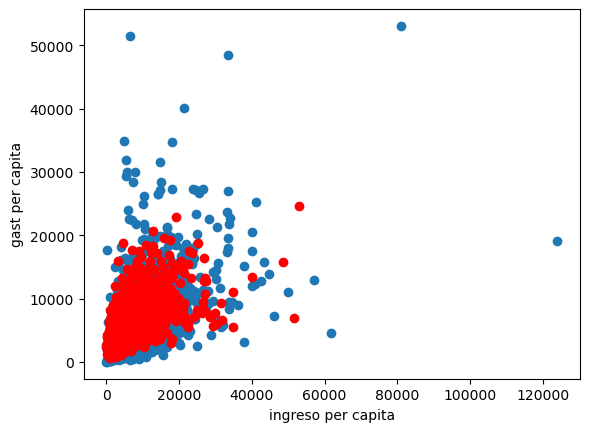

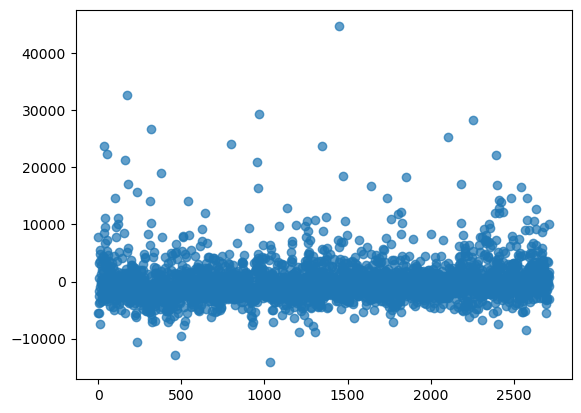

In [11]:
  #Region 4
fdata_nea = filtro1(data, 4, region=True)
n = fdata_nea.shape[0]
'''
X = fdata_nea['ingpch']
X = sm.add_constant(X)
y = fdata_nea[['gastotpc']]
reg1 = sm.OLS(y, X).fit()
print(reg1.summary())
'''
X = fdata_nea[['ingpch','ingpch2','clima_educativo', 'asalariado', 'casado','regten', 'propauto', 'edad_25/34', 'edad_35/49', 'edad65_mas']]
X = sm.add_constant(X)
y = fdata_nea[['gastotpc']]
reg2 = sm.OLS(y, X).fit()
print(reg2.summary())
predicciones = reg2.predict(X)
plt.scatter(fdata_nea['ingpch'],fdata_nea['gastotpc'])
plt.scatter(fdata_nea['gastotpc'], predicciones, label='Valores predichos', color='red')
plt.ylabel('gast per capita')
plt.xlabel('ingreso per capita')
plt.show()
residuos = reg2.resid
plt.scatter(range(len(residuos)), residuos, alpha=0.7)
plt.show()

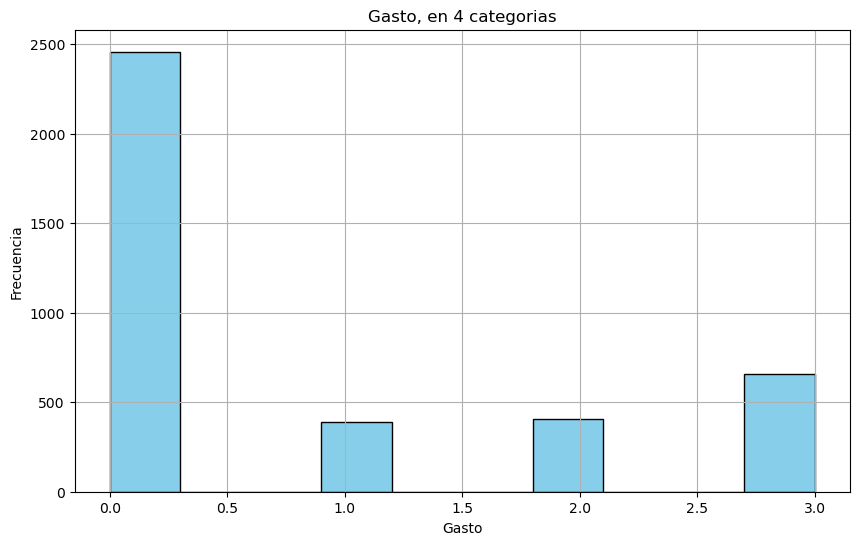

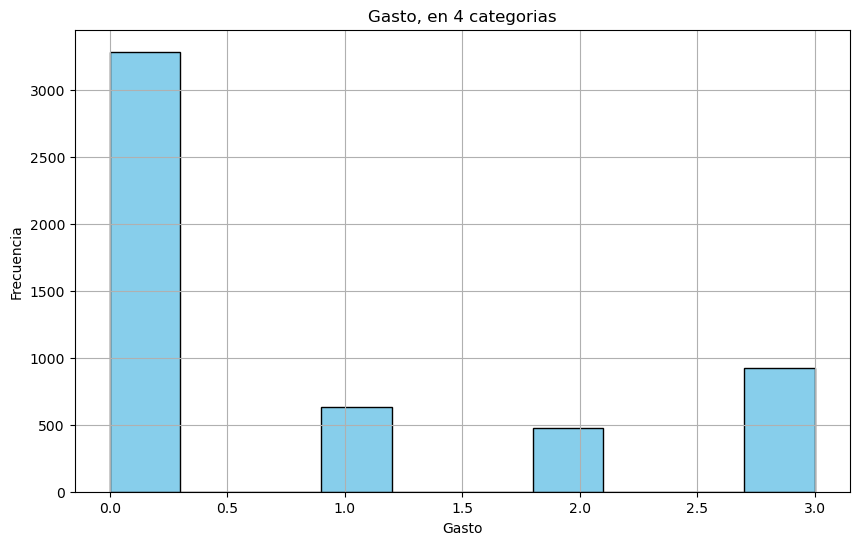

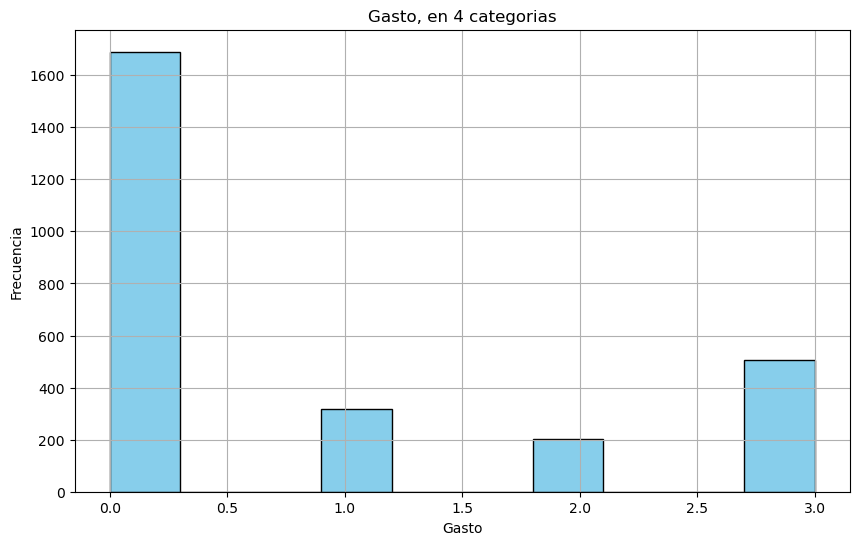

In [13]:
plot_histograma_gasto(fdata_metro)
plot_histograma_gasto(fdata_pampe)
plot_histograma_gasto(fdata_nea)


In [ ]:
plot_histograma_gasto_percapita(fdata_metro)
plot_histograma_gasto_percapita(fdata_pampe)
plot_histograma_gasto_percapita(fdata_nea)

In [ ]:
plot_histograma_ingpch(fdata_metro)
plot_histograma_ingpch(fdata_pampe)
plot_histograma_ingpch(fdata_nea)

In [ ]:
plot_bar_gasto_educacion(fdata_metro)
plot_bar_gasto_educacion(fdata_pampe)
plot_bar_gasto_educacion(fdata_nea)